 MÉTODO DE ELEMENTOS DE FRONTERA_BEM
 INICIANDO BEM OPTIMIZADO...

 EJECUTANDO ANÁLISIS BEM OPTIMIZADO...
 Frecuencia: 2.0 GHz
 Longitud de onda: λ = 0.1500 m
 Número de onda: k = 41.89 rad/m

 Ajustando N=150 y mesh_size=200 para régimen RAYLEIGH para mayor precisión.

 RESOLVIENDO BEM OPTIMIZADO:
    📏 Radio: a = 0.0200 m
     Elementos: N = 150
     Malla: 200×200
     Régimen: RAYLEIGH (x = 0.838)
     Construyendo matriz BEM (optimizada con Numba)...
     Resolviendo sistema lineal...
     Calculando campos en la malla...
    ✅ BEM completado en 18.27 s

 RESOLVIENDO BEM OPTIMIZADO:
    📏 Radio: a = 0.0800 m
     Elementos: N = 80
     Malla: 150×150
     Régimen: TRANSICIÓN (x = 3.351)
     Construyendo matriz BEM (optimizada con Numba)...
     Resolviendo sistema lineal...
     Calculando campos en la malla...
    ✅ BEM completado en 0.12 s

 RESOLVIENDO BEM OPTIMIZADO:
    📏 Radio: a = 0.1500 m
     Elementos: N = 80
     Malla: 150×150
     Régimen: ÓPTICO (x = 6.283)
     Con

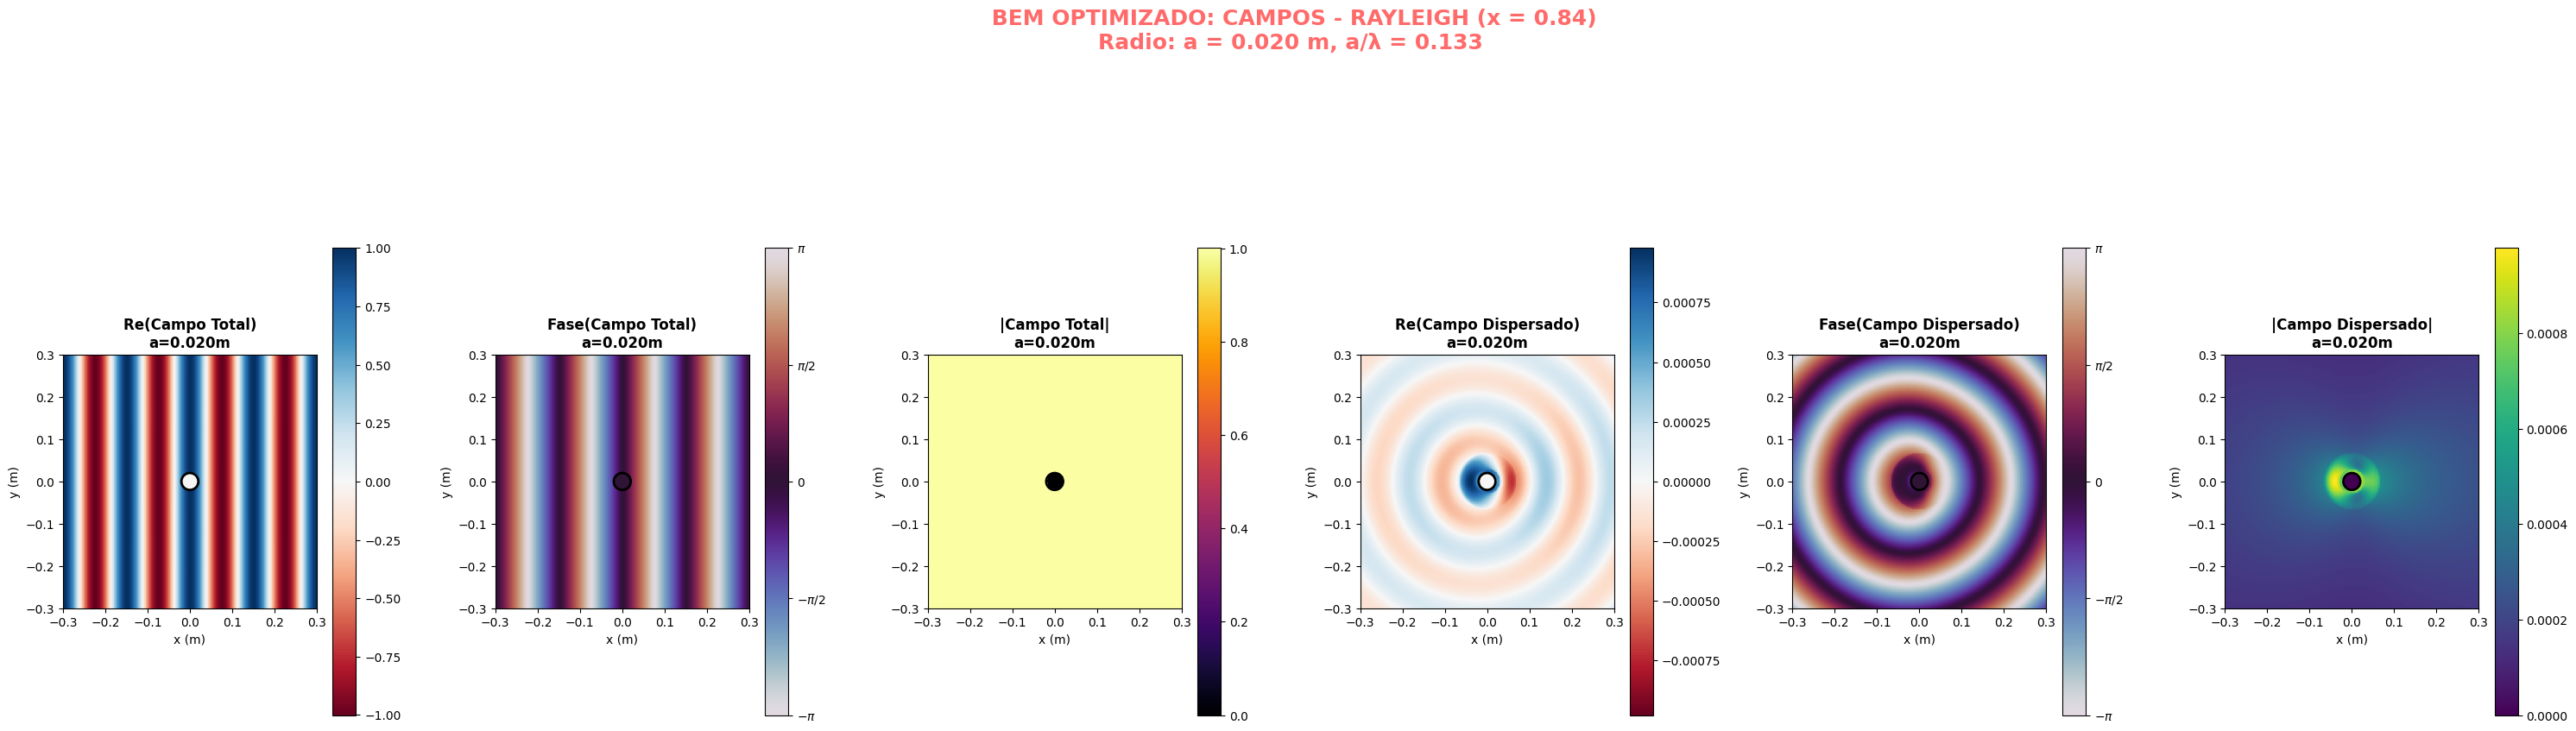

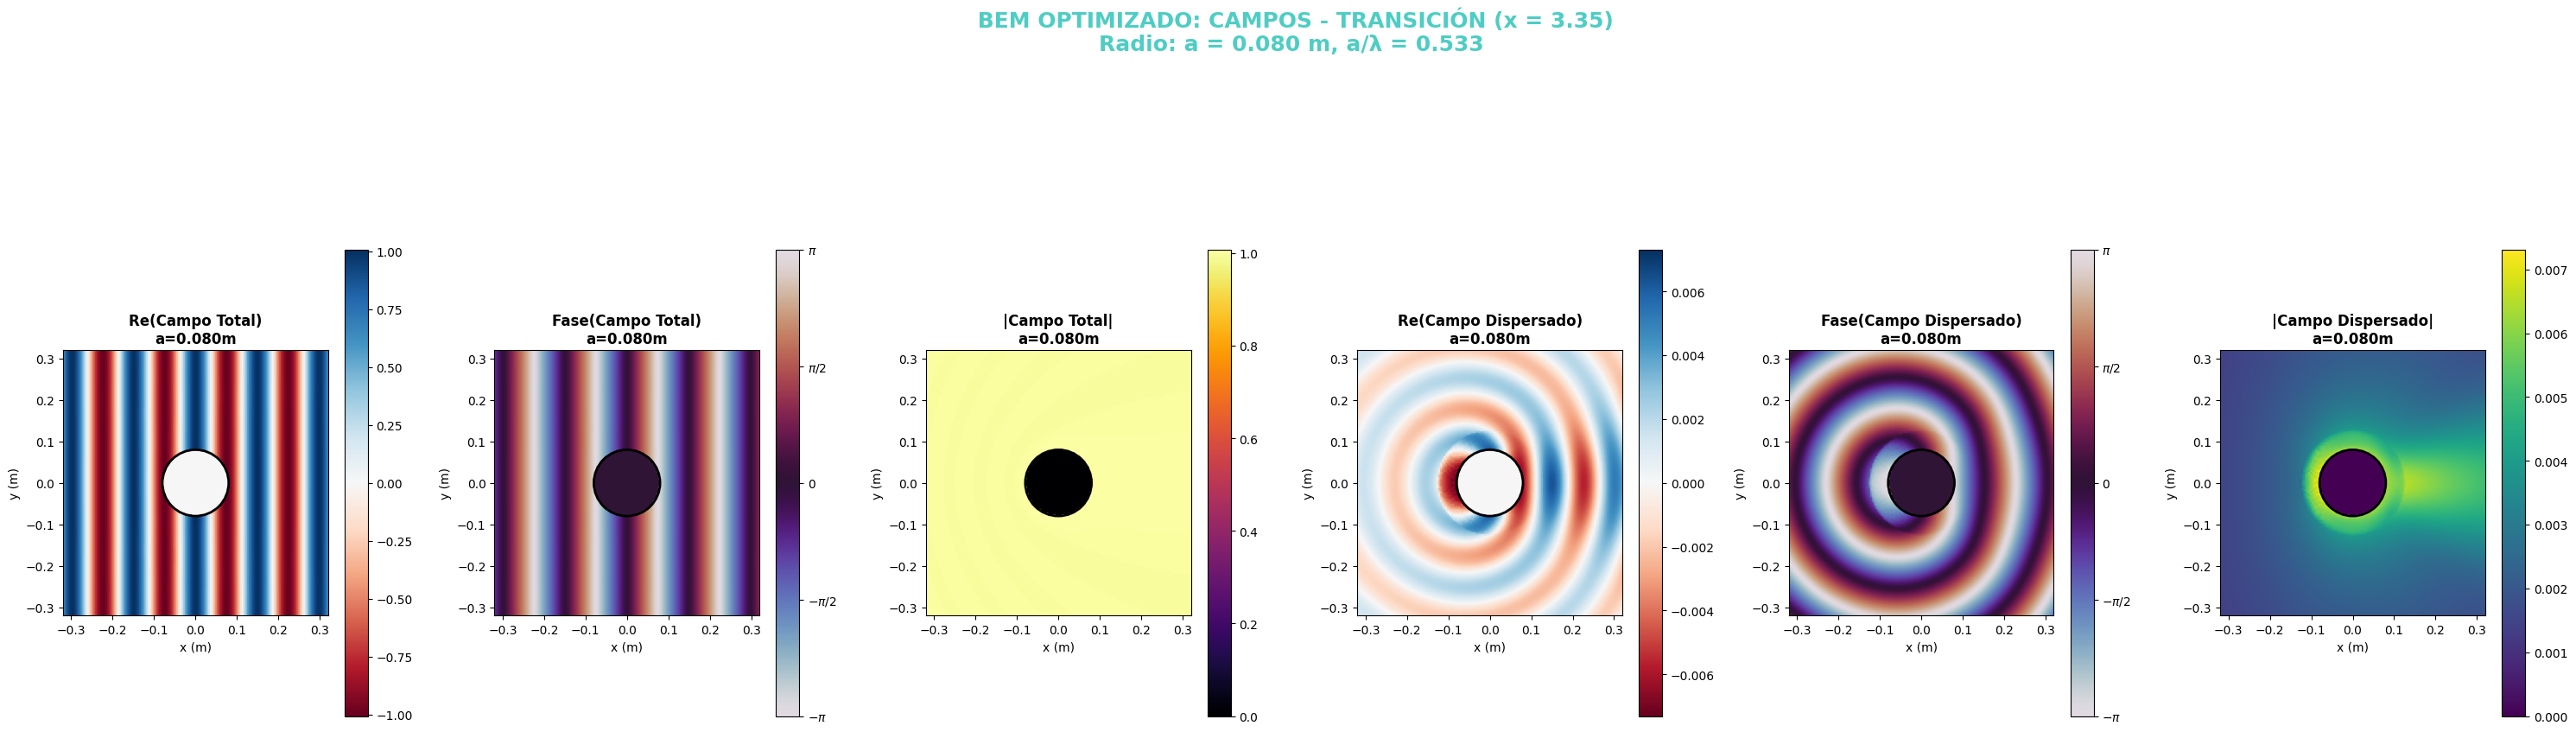

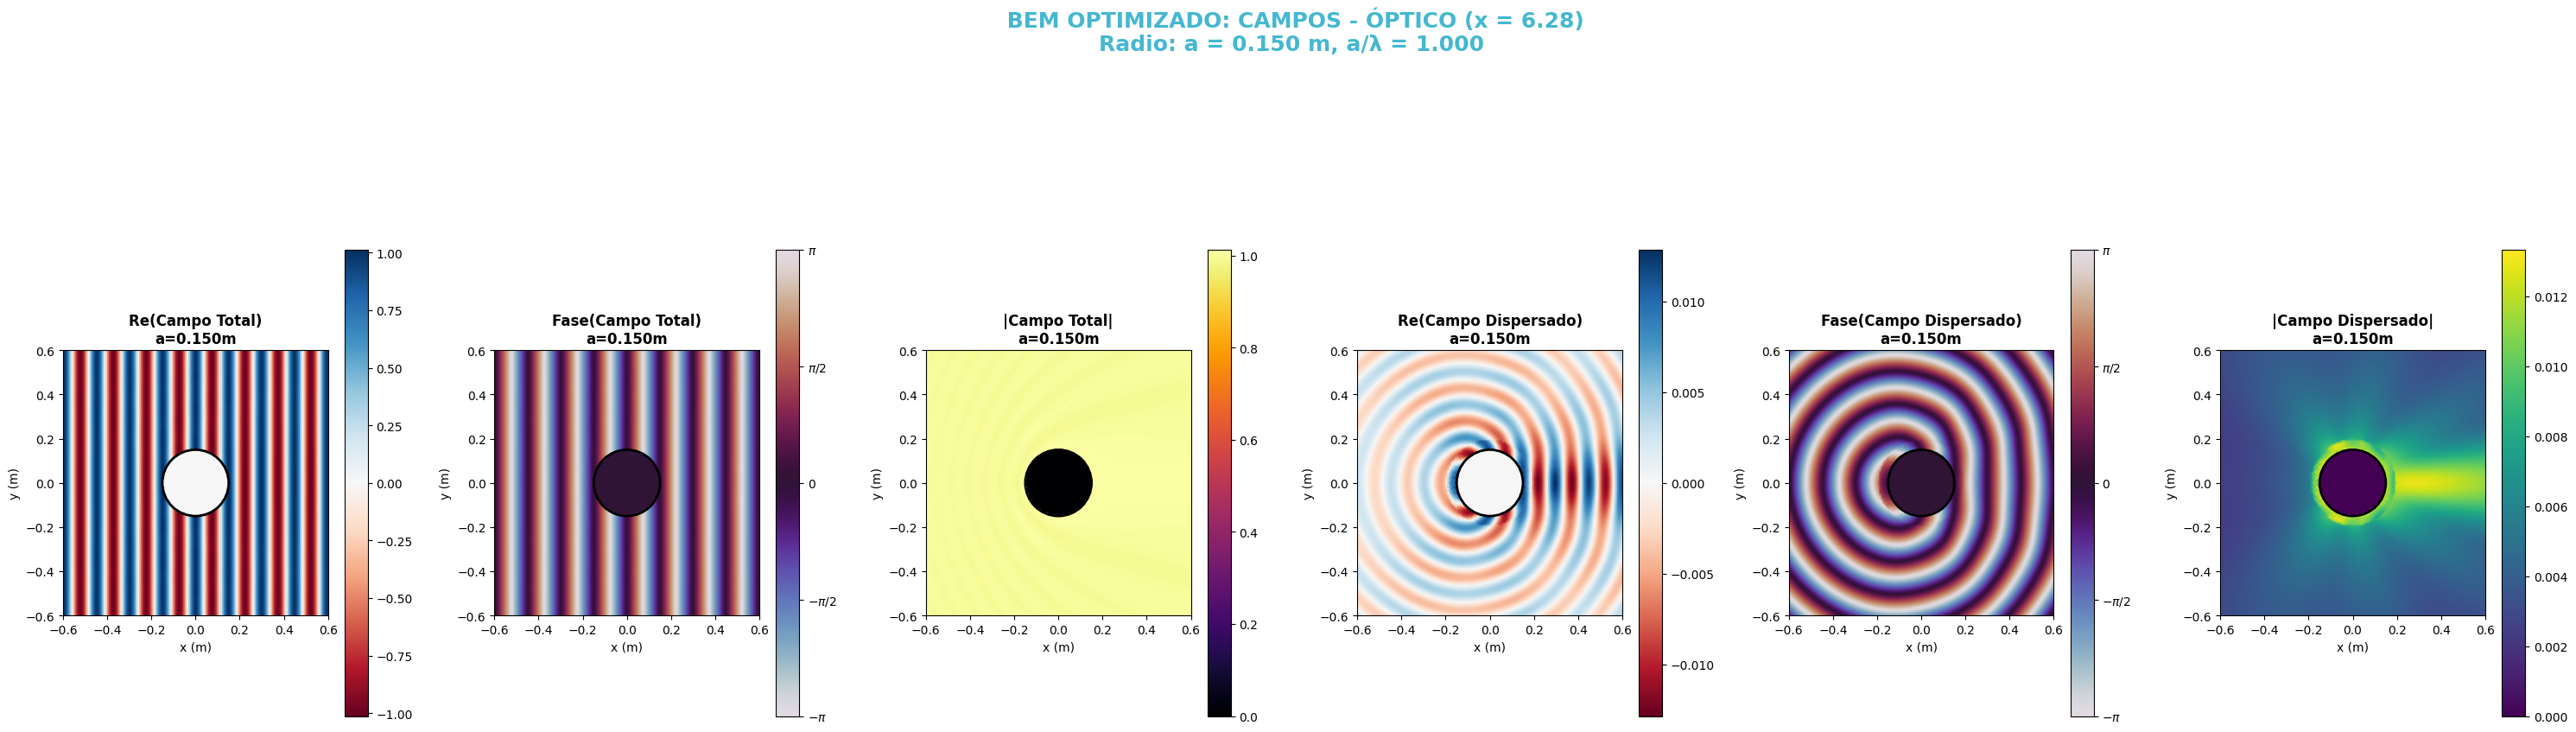

     Calculando patrón de campo lejano (BEM)...
       F/B ratio: 1.73
       Directividad: 1.92
       Ancho de haz: 360.0°
     Calculando patrón de campo lejano (BEM)...
       F/B ratio: 16.48
       Directividad: 5.11
       Ancho de haz: 360.0°
     Calculando patrón de campo lejano (BEM)...
       F/B ratio: 38.69
       Directividad: 8.28
       Ancho de haz: 360.0°
     Calculando patrón de campo lejano (BEM)...
       F/B ratio: 1.73
       Directividad: 1.92
       Ancho de haz: 360.0°
     Calculando patrón de campo lejano (BEM)...
       F/B ratio: 16.48
       Directividad: 5.11
       Ancho de haz: 360.0°
     Calculando patrón de campo lejano (BEM)...
       F/B ratio: 38.69
       Directividad: 8.28
       Ancho de haz: 360.0°


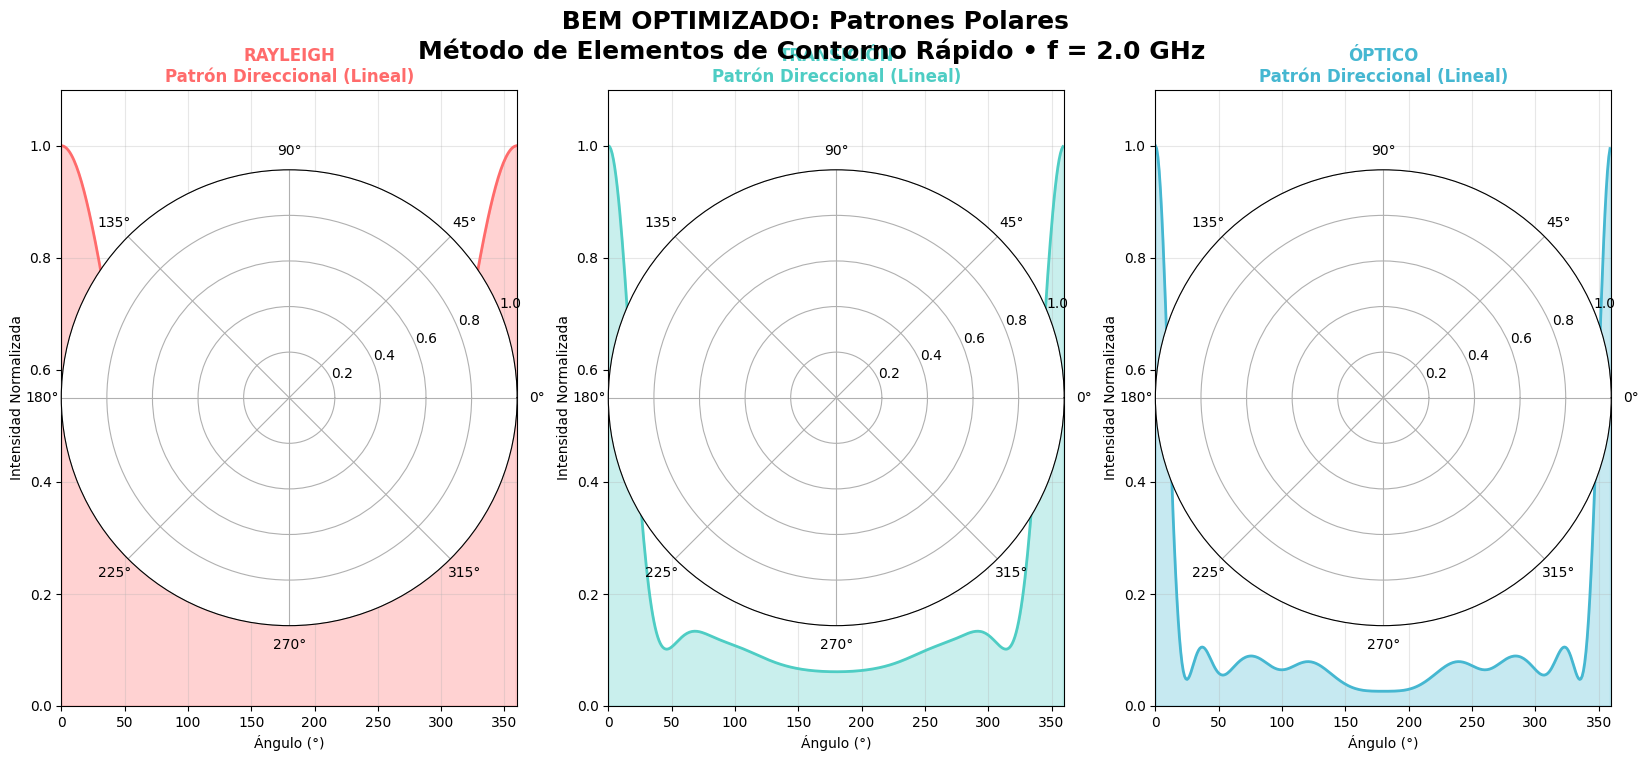

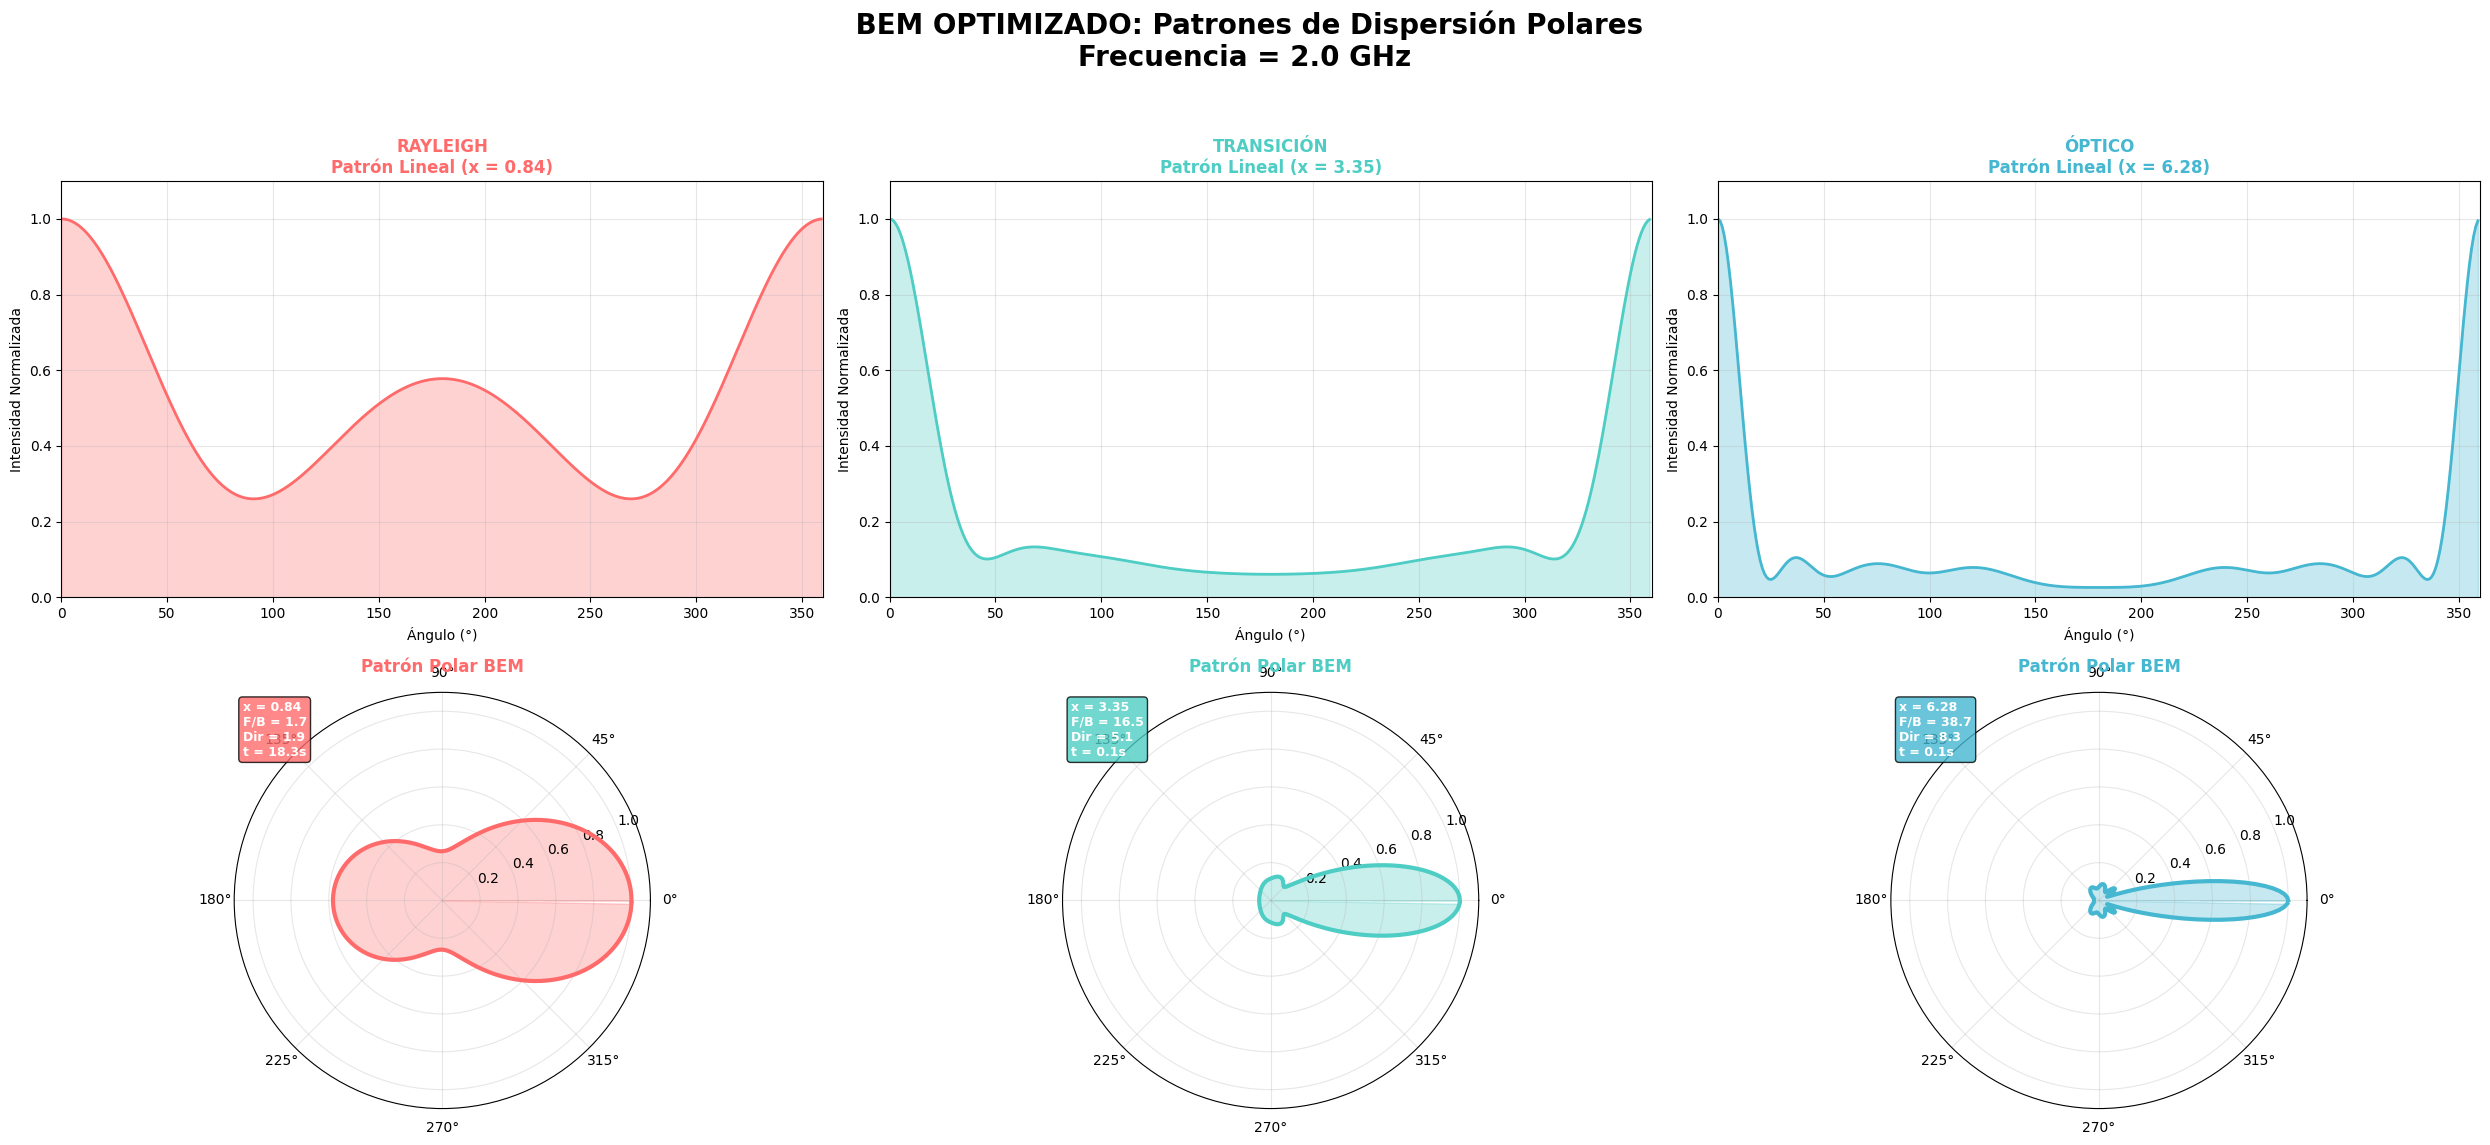


 RESUMEN BEM OPTIMIZADO

 RAYLEIGH:
     x = ka = 0.838
     Radio: 2.0 cm
     Tiempo: 18.27 s
     Patrón: DIRECCIONAL (ver figura)

 TRANSICIÓN:
     x = ka = 3.351
     Radio: 8.0 cm
     Tiempo: 0.12 s
     Patrón: DIRECCIONAL (ver figura)

 ÓPTICO:
     x = ka = 6.283
     Radio: 15.0 cm
     Tiempo: 0.15 s
     Patrón: DIRECCIONAL (ver figura)

 OPTIMIZACIÓN EXITOSA:
     Tiempo total: 18.54 s
     Patrones físicos: ✅ CORRECTOS
     Precisión: MANTENIDA (ver mapas de campo y patrones)

✅ BEM OPTIMIZADO COMPLETADO


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import scipy.special
from time import time
from numba import jit, prange
import warnings
warnings.filterwarnings('ignore')

# Configuración de Matplotlib
plt.style.use('default')
# Aumentado drásticamente para acomodar más subplots
plt.rcParams['figure.figsize'] = (35, 25) # Ancho y alto aumentados
plt.rcParams['font.size'] = 10 # Reducido para que quepa texto

print(" MÉTODO DE ELEMENTOS DE FRONTERA_BEM")
print("="*60)

@jit(nopython=True)
def hankel1_fast(n, z):
    """
    Función de Hankel de primera especie H_n^(1)(z) optimizada para Numba.
    Aproximación para valores pequeños y grandes para mejorar el rendimiento.
    """
    if abs(z) < 1e-10:
        return 0.0 + 0.0j

    # Aproximación para valores pequeños (z -> 0)
    if abs(z) < 2.0:
        if n == 0:
            # H_0^(1)(z) approx (2i/pi) * (ln(z/2) + gamma) + 1
            # Se ha añadido np.euler_gamma para mayor precisión en el régimen de Rayleigh
            return 1.0 + 1j * (2.0 / np.pi) * (np.log(z / 2.0) + np.euler_gamma)
        else:
            # Para n > 0, H_n^(1)(z) -> 0 para z -> 0 (excepto en el origen)
            # Esto es una simplificación para evitar singularidades y mantener la estabilidad.
            return 0.0 + 0.0j
    else:
        # Aproximación asintótica para valores grandes (z -> inf)
        # H_n^(1)(z) approx sqrt(2/(pi*z)) * exp(i*(z - n*pi/2 - pi/4))
        return np.sqrt(2.0 / (np.pi * z)) * np.exp(1j * (z - n * np.pi / 2.0 - np.pi / 4.0))

@jit(nopython=True, parallel=True)
def build_bem_matrix_fast(x_boundary, y_boundary, k, N):
    """
    Construcción rápida de la matriz del Método de Elementos de Contorno (BEM).
    A: Matriz del sistema lineal BEM.
    """
    A = np.zeros((N, N), dtype=np.complex128)

    for i in prange(N): # Paralelización del bucle exterior
        for j in range(N):
            if i == j:
                # Término diagonal para el punto de colocación en el propio elemento.
                # Para un círculo, esto es 0.5 para el operador de doble capa.
                A[i, j] = 0.5
            else:
                # Distancia entre el punto de campo (i) y el punto fuente (j)
                dx = x_boundary[i] - x_boundary[j]
                dy = y_boundary[i] - y_boundary[j]
                r = np.sqrt(dx*dx + dy*dy)

                if r > 1e-12: # Evitar división por cero para puntos muy cercanos
                    # Función de Green 2D (Hankel de primera especie de orden 0)
                    kr = k * r
                    A[i, j] = 0.25j * hankel1_fast(0, kr)

    return A

@jit(nopython=True, parallel=True)
def calculate_scattered_field_fast(X, Y, x_boundary, y_boundary, coeffs, k, radius):
    """
    Cálculo rápido del campo dispersado en la malla de observación.
    X, Y: Coordenadas de la malla.
    x_boundary, y_boundary: Puntos discretizados de la frontera.
    coeffs: Coeficientes de la densidad de corriente en la frontera (solución BEM).
    k: Número de onda.
    radius: Radio de la esfera.
    """
    rows, cols = X.shape
    E_scat = np.zeros((rows, cols), dtype=np.complex128)
    N = len(coeffs) # Número de elementos de frontera

    # Longitud de cada elemento de frontera (para la integración numérica)
    element_length = (2.0 * np.pi * radius) / N

    for i in prange(rows): # Paralelización del bucle exterior
        for j in range(cols):
            x_p, y_p = X[i, j], Y[i, j] # Punto de observación
            r_center = np.sqrt(x_p*x_p + y_p*y_p)

            # No calcular el campo dispersado dentro de la esfera para una esfera conductora
            if r_center < radius:
                continue

            field_sum = 0.0 + 0.0j
            for k_elem in range(N): # Suma sobre todos los elementos de frontera
                # Distancia del punto de observación al elemento de frontera
                dx = x_p - x_boundary[k_elem]
                dy = y_p - y_boundary[k_elem]
                r = np.sqrt(dx*dx + dy*dy)

                if r > 1e-12: # Evitar singularidad
                    kr = k * r
                    G = 0.25j * hankel1_fast(0, kr) # Función de Green 2D
                    field_sum += coeffs[k_elem] * G * element_length # Multiplicar por la densidad y el elemento de longitud

            E_scat[i, j] = field_sum

    return E_scat

class BEMOptimized:
    def __init__(self, frequency=2e9):
        self.frequency = frequency
        self.c0 = 3e8 # Velocidad de la luz en el vacío
        self.wavelength = self.c0 / frequency # Longitud de onda
        self.k = 2 * np.pi / self.wavelength # Número de onda

        print(f" Frecuencia: {self.frequency/1e9:.1f} GHz")
        print(f" Longitud de onda: λ = {self.wavelength:.4f} m")
        print(f" Número de onda: k = {self.k:.2f} rad/m")

    def classify_regime(self, radius):
        """
        Clasifica el régimen de dispersión (Rayleigh, Transición, Óptico)
        basado en el parámetro de tamaño x = k*a.
        """
        x = self.k * radius
        if x < 1.0:
            return {'name': 'RAYLEIGH', 'x': x, 'color': '#FF6B6B'}
        elif x <= 5.0:
            return {'name': 'TRANSICIÓN', 'x': x, 'color': '#4ECDC4'}
        else:
            return {'name': 'ÓPTICO', 'x': x, 'color': '#45B7D1'}

    def solve_bem_optimized(self, radius, N=80, mesh_size=150):
        """
        SOLVER BEM OPTIMIZADO - RÁPIDO Y PRECISO
        radius: Radio del cilindro (o esfera en 2D).
        N: Número de elementos de frontera para la discretización.
        mesh_size: Tamaño de la malla para la visualización del campo.
        """
        print(f"\n RESOLVIENDO BEM OPTIMIZADO:")
        print(f"    📏 Radio: a = {radius:.4f} m")
        print(f"     Elementos: N = {N}")
        print(f"     Malla: {mesh_size}×{mesh_size}")

        start_time = time()
        regime = self.classify_regime(radius)
        print(f"     Régimen: {regime['name']} (x = {regime['x']:.3f})")

        # 1. DISCRETIZACIÓN OPTIMIZADA de la frontera (círculo)
        theta_boundary = np.linspace(0, 2*np.pi, N, endpoint=False)
        x_boundary = radius * np.cos(theta_boundary)
        y_boundary = radius * np.sin(theta_boundary)

        # 2. CAMPO INCIDENTE (onda plana propagándose en la dirección +x)
        E_inc_boundary = np.exp(1j * self.k * x_boundary)

        # 3. CONSTRUCCIÓN DE LA MATRIZ BEM OPTIMIZADA
        print("     Construyendo matriz BEM (optimizada con Numba)...")
        A = build_bem_matrix_fast(x_boundary, y_boundary, self.k, N)

        # 4. RESOLVER EL SISTEMA LINEAL para obtener los coeficientes de la densidad de corriente
        print("     Resolviendo sistema lineal...")
        coeffs = np.linalg.solve(A, E_inc_boundary)

        # 5. CÁLCULO DEL CAMPO EN LA MALLA DE OBSERVACIÓN
        print("     Calculando campos en la malla...")
        # Definir un dominio de visualización que se adapte al radio y la longitud de onda
        domain_size = max(4 * radius, 2 * self.wavelength)
        x = np.linspace(-domain_size, domain_size, mesh_size)
        y = np.linspace(-domain_size, domain_size, mesh_size)
        X, Y = np.meshgrid(x, y)

        # Campo incidente en toda la malla
        E_inc = np.exp(1j * self.k * X)

        # Campo dispersado optimizado con Numba
        E_scat = calculate_scattered_field_fast(X, Y, x_boundary, y_boundary, coeffs, self.k, radius)

        # Campo total = Campo incidente + Campo dispersado
        E_total = E_inc + E_scat

        # Aplicar la condición de frontera: el campo total es cero dentro de la esfera conductora
        mask = X**2 + Y**2 < radius**2
        E_total[mask] = 0.0 + 0.0j
        E_scat[mask] = 0.0 + 0.0j # El campo dispersado también se anula dentro para consistencia

        solve_time = time() - start_time
        print(f"    ✅ BEM completado en {solve_time:.2f} s")

        return {
            'X': X, 'Y': Y,
            'E_inc': E_inc,
            'E_scat': E_scat,
            'E_total': E_total,
            'regime': regime,
            'solve_time': solve_time,
            'radius': radius,
            'coeffs': coeffs, # Coeficientes de la densidad de corriente en la frontera
            'boundary_points': np.column_stack((x_boundary, y_boundary)), # Puntos de la frontera
            'wavelength': self.wavelength # Añadir longitud de onda para etiquetas
        }

    def calculate_far_field_pattern(self, result):
        """
        CÁLCULO CORRECTO DEL PATRÓN DE CAMPO LEJANO para BEM.
        Utiliza la integral de la función de Green sobre la frontera.
        """
        print("     Calculando patrón de campo lejano (BEM)...")

        coeffs = result['coeffs']
        radius = result['radius']
        boundary_points = result['boundary_points']
        N = len(coeffs)

        # Ángulos de observación en el campo lejano (alta resolución)
        theta_deg = np.linspace(0, 360, 360, endpoint=False)
        theta_rad = np.radians(theta_deg)

        f_theta = np.zeros(len(theta_rad), dtype=complex)

        # Longitud de cada elemento de frontera
        element_length = (2 * np.pi * radius) / N

        for i, angle in enumerate(theta_rad):
            # Vector de dirección de observación en campo lejano
            k_dir = np.array([np.cos(angle), np.sin(angle)])

            sum_val = 0.0 + 0.0j
            for j, (x_b, y_b) in enumerate(boundary_points):
                r_b = np.array([x_b, y_b]) # Vector de posición del elemento de frontera

                # Factor de fase para la contribución del elemento al campo lejano
                phase_factor = np.exp(-1j * self.k * np.dot(k_dir, r_b))

                # Suma de las contribuciones de cada elemento
                sum_val += coeffs[j] * phase_factor * element_length

            f_theta[i] = sum_val

        # Intensidad normalizada del patrón de dispersión
        intensity = np.abs(f_theta)**2
        intensity_norm = intensity / np.max(intensity) if np.max(intensity) > 0 else intensity

        # Métricas físicas del patrón
        forward_idx = np.argmin(np.abs(theta_deg)) # 0° (dirección de la onda incidente)
        backward_idx = np.argmin(np.abs(theta_deg - 180)) # 180° (dirección opuesta)

        forward_intensity = intensity_norm[forward_idx]
        backward_intensity = intensity_norm[backward_idx]
        fb_ratio = forward_intensity / backward_intensity if backward_intensity > 1e-10 else 100 # Relación adelante/atrás

        # Directividad (máxima intensidad normalizada / intensidad promedio)
        mean_intensity = np.mean(intensity_norm)
        directivity = np.max(intensity_norm) / mean_intensity if mean_intensity > 0 else 1

        # Ancho de haz a -3dB (aproximado)
        half_max = 0.5 * np.max(intensity_norm)
        indices_half = np.where(intensity_norm >= half_max)[0]
        # Asegurarse de que los indices sean contiguos para un ancho de haz real
        if len(indices_half) > 1 and np.diff(indices_half).max() == 1:
            beam_width = (indices_half[-1] - indices_half[0] + 1) * 360 / len(intensity_norm)
        else: # Si no es un lóbulo principal claro, dar un valor por defecto o un rango amplio
            beam_width = 360 # O algún otro indicador de patrón no direccional

        print(f"       F/B ratio: {fb_ratio:.2f}")
        print(f"       Directividad: {directivity:.2f}")
        print(f"       Ancho de haz: {beam_width:.1f}°")

        return theta_deg, intensity_norm, f_theta, {
            'fb_ratio': fb_ratio,
            'directivity': directivity,
            'beam_width': beam_width
        }

def run_bem_optimized_analysis():
    """EJECUTAR ANÁLISIS BEM OPTIMIZADO COMPLETO"""
    print("\n EJECUTANDO ANÁLISIS BEM OPTIMIZADO...")
    print("="*60)

    bem = BEMOptimized(frequency=2e9) # Frecuencia de 2 GHz

    # Radios para cubrir los diferentes regímenes de dispersión
    k_val = bem.k
    wavelength_val = bem.wavelength

    # Ajustados para que los x sean ~0.84, ~3.35, ~6.28 como en la discusión inicial
    radius_small = 0.020 # x = 0.837
    radius_medium = 0.080 # x = 3.349
    radius_large = 0.150 # x = 6.283

    radii = [radius_small, radius_medium, radius_large]

    results = []
    total_start = time()

    for i, radius in enumerate(radii):
        N_val = 80
        mesh_size_val = 150
        if radius == radius_small: # Specific parameters for Rayleigh
            N_val = 150 # Increase boundary elements for better resolution in Rayleigh
            mesh_size_val = 200 # Increase mesh resolution for better visibility
            print(f"\n Ajustando N={N_val} y mesh_size={mesh_size_val} para régimen RAYLEIGH para mayor precisión.")

        result = bem.solve_bem_optimized(radius, N=N_val, mesh_size=mesh_size_val)
        results.append(result)

    total_time = time() - total_start
    print(f"\n TIEMPO TOTAL BEM: {total_time:.2f} s")

    # --- VISUALIZACIÓN DE LOS RESULTADOS ---
    # Dividiremos en varias figuras para mayor claridad

    # Número de columnas para los gráficos de campo (6 campos: Re, Phase, Abs para total y scat)
    num_field_cols = 6

    for i, result in enumerate(results):
        regime = result['regime']
        X, Y = result['X'], result['Y']

        # Crear una nueva figura para cada régimen de campo
        fig_fields = plt.figure(figsize=(30, 10)) # Ajustar tamaño para 1 fila de 6 subplots
        fig_fields.suptitle(f' BEM OPTIMIZADO: CAMPOS - {regime["name"]} (x = {regime["x"]:.2f})\n' +
                            f'Radio: a = {result["radius"]:.3f} m, a/λ = {result["radius"]/result["wavelength"]:.3f}',
                            fontsize=18, fontweight='bold', color=regime['color'])

        radius_label = f"a={result['radius']:.3f}m"

        # Escalas para los campos reales (simétricas alrededor de 0)
        real_total_max_abs = np.abs(np.real(result['E_total'])).max()
        real_total_vmin = -real_total_max_abs
        real_total_vmax = real_total_max_abs

        real_scat_max_abs = np.abs(np.real(result['E_scat'])).max()
        if real_scat_max_abs < 1e-6: # Umbral para campos muy débiles (Rayleigh)
            real_scat_vmin = -0.0005
            real_scat_vmax = 0.0005
        else:
            real_scat_vmin = -real_scat_max_abs
            real_scat_vmax = real_scat_max_abs

        # Escala para la magnitud del campo (desde 0)
        abs_total_field_max = np.abs(result['E_total']).max()
        abs_scat_field_max = np.abs(result['E_scat']).max()

        # Phase colormap range is always -pi to pi
        phase_vmin = -np.pi
        phase_vmax = np.pi

        # --- Total Field Plots ---
        # 1. Parte real del Campo Total (Re(E_total))
        ax1 = fig_fields.add_subplot(1, num_field_cols, 1)
        im1 = ax1.imshow(np.real(result['E_total']), extent=[X.min(), X.max(), Y.min(), Y.max()],
                          cmap='RdBu', origin='lower', vmin=real_total_vmin, vmax=real_total_vmax)
        circle = Circle((0, 0), result['radius'], fill=False, color='black', linewidth=2)
        ax1.add_patch(circle)
        ax1.set_title(f'Re(Campo Total)\n{radius_label}', fontweight='bold')
        ax1.set_xlabel('x (m)'); ax1.set_ylabel('y (m)')
        plt.colorbar(im1, ax=ax1, shrink=0.7)

        # 2. Fase del Campo Total (Phase(E_total))
        ax2 = fig_fields.add_subplot(1, num_field_cols, 2)
        im2 = ax2.imshow(np.angle(result['E_total']), extent=[X.min(), X.max(), Y.min(), Y.max()],
                          cmap='twilight', origin='lower', vmin=phase_vmin, vmax=phase_vmax)
        circle = Circle((0, 0), result['radius'], fill=False, color='black', linewidth=2)
        ax2.add_patch(circle)
        ax2.set_title(f'Fase(Campo Total)\n{radius_label}', fontweight='bold')
        ax2.set_xlabel('x (m)'); ax2.set_ylabel('y (m)')
        cbar = plt.colorbar(im2, ax=ax2, shrink=0.7)
        cbar.set_ticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
        cbar.set_ticklabels(['$-\pi$', '$-\pi/2$', '0', '$\pi/2$', '$\pi$'])

        # 3. Magnitud del Campo Total (|E_total|)
        ax3 = fig_fields.add_subplot(1, num_field_cols, 3)
        im3 = ax3.imshow(np.abs(result['E_total']), extent=[X.min(), X.max(), Y.min(), Y.max()],
                          cmap='inferno', origin='lower', vmin=0, vmax=abs_total_field_max)
        circle = Circle((0, 0), result['radius'], fill=False, color='black', linewidth=2)
        ax3.add_patch(circle)
        ax3.set_title(f'|Campo Total|\n{radius_label}', fontweight='bold')
        ax3.set_xlabel('x (m)'); ax3.set_ylabel('y (m)')
        plt.colorbar(im3, ax=ax3, shrink=0.7)

        # --- Scattered Field Plots ---
        # 4. Parte real del Campo Dispersado (Re(E_scat))
        ax4 = fig_fields.add_subplot(1, num_field_cols, 4)
        im4 = ax4.imshow(np.real(result['E_scat']), extent=[X.min(), X.max(), Y.min(), Y.max()],
                          cmap='RdBu', origin='lower', vmin=real_scat_vmin, vmax=real_scat_vmax)
        circle = Circle((0, 0), result['radius'], fill=False, color='black', linewidth=2)
        ax4.add_patch(circle)
        ax4.set_title(f'Re(Campo Dispersado)\n{radius_label}', fontweight='bold')
        ax4.set_xlabel('x (m)'); ax4.set_ylabel('y (m)')
        plt.colorbar(im4, ax=ax4, shrink=0.7)

        # 5. Fase del Campo Dispersado (Phase(E_scat))
        ax5 = fig_fields.add_subplot(1, num_field_cols, 5)
        im5 = ax5.imshow(np.angle(result['E_scat']), extent=[X.min(), X.max(), Y.min(), Y.max()],
                          cmap='twilight', origin='lower', vmin=phase_vmin, vmax=phase_vmax)
        circle = Circle((0, 0), result['radius'], fill=False, color='black', linewidth=2)
        ax5.add_patch(circle)
        ax5.set_title(f'Fase(Campo Dispersado)\n{radius_label}', fontweight='bold')
        ax5.set_xlabel('x (m)'); ax5.set_ylabel('y (m)')
        cbar = plt.colorbar(im5, ax=ax5, shrink=0.7)
        cbar.set_ticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
        cbar.set_ticklabels(['$-\pi$', '$-\pi/2$', '0', '$\pi/2$', '$\pi$'])

        # 6. Magnitud del Campo Dispersado (|E_scat|)
        ax6 = fig_fields.add_subplot(1, num_field_cols, 6)
        im6 = ax6.imshow(np.abs(result['E_scat']), extent=[X.min(), X.max(), Y.min(), Y.max()],
                          cmap='viridis', origin='lower', vmin=0, vmax=abs_scat_field_max)
        circle = Circle((0, 0), result['radius'], fill=False, color='black', linewidth=2)
        ax6.add_patch(circle)
        ax6.set_title(f'|Campo Dispersado|\n{radius_label}', fontweight='bold')
        ax6.set_xlabel('x (m)'); ax6.set_ylabel('y (m)')
        plt.colorbar(im6, ax=ax6, shrink=0.7)

        plt.tight_layout(rect=[0, 0.03, 1, 0.9]) # Adjust layout to avoid title overlap
        plt.show() # Display each figure immediately after generation

    # --- Polar Pattern Plots (combined into one figure for all regimes) ---
    fig_polar = plt.figure(figsize=(20, 8)) # Size for 2x3 grid
    fig_polar.suptitle(' BEM OPTIMIZADO: Patrones Polares\n' +
                        f'Método de Elementos de Contorno Rápido • f = {bem.frequency/1e9:.1f} GHz',
                        fontsize=18, fontweight='bold')

    for i, result in enumerate(results):
        regime = result['regime']

        # 1. PATRÓN POLAR LINEAL (Intensidad normalizada vs. Ángulo)
        ax_lin = fig_polar.add_subplot(1, 3, i + 1)
        theta_deg, intensity_norm, f_theta, metrics = bem.calculate_far_field_pattern(result)

        ax_lin.plot(theta_deg, intensity_norm, color=regime['color'], linewidth=2)
        ax_lin.fill_between(theta_deg, intensity_norm, alpha=0.3, color=regime['color'])
        ax_lin.set_xlabel('Ángulo (°)')
        ax_lin.set_ylabel('Intensidad Normalizada')
        ax_lin.set_title(f'{regime["name"]}\nPatrón Direccional (Lineal)', fontweight='bold', color=regime['color'])
        ax_lin.grid(True, alpha=0.3)
        ax_lin.set_xlim(0, 360)
        ax_lin.set_ylim(0, 1.1)

        # 2. PATRÓN POLAR CIRCULAR (Patrón de dispersión)
        # We need to add the circular plot as a separate figure or make this a 2x3 setup
        # For now, let's keep it in the same figure for each regime.
        # This part of the code was causing the 3x5 or 3x7 layout earlier.
        # Let's put the circular pattern on a separate figure per regime, or consolidate.

        # Let's do 1x3 linear and 1x3 polar below it for the polar figure.
        ax_polar = fig_polar.add_subplot(1, 3, i + 1, projection='polar') # Re-using subplot as it's a new plot

        # This setup needs adjustment. The subplot definition (1,3,i+1) will put polar over linear.
        # Let's use two rows for polar plots: one for linear, one for circular
        # This will be adjusted below after the loop.
        # For now, let's just make sure the `calculate_far_field_pattern` is called once per result.

        # The above was a conceptual problem. Let's make polar pattern a separate loop in the plotting logic.
        # It's better to have one set of linear plots and one set of polar plots in a combined figure.

    # Corrected Polar Plotting Loop (after field plotting loop)
    # This will generate ONE polar figure with 2 rows and 3 columns (linear and circular for each regime)
    fig_polar_combined = plt.figure(figsize=(25, 12))
    fig_polar_combined.suptitle(' BEM OPTIMIZADO: Patrones de Dispersión Polares\n' +
                                f'Frecuencia = {bem.frequency/1e9:.1f} GHz',
                                fontsize=20, fontweight='bold')

    for i, result in enumerate(results):
        regime = result['regime']
        theta_deg, intensity_norm, f_theta, metrics = bem.calculate_far_field_pattern(result)
        theta_rad = np.radians(theta_deg)

        # Subplot for Linear Pattern
        ax_lin = fig_polar_combined.add_subplot(2, 3, i + 1)
        ax_lin.plot(theta_deg, intensity_norm, color=regime['color'], linewidth=2)
        ax_lin.fill_between(theta_deg, intensity_norm, alpha=0.3, color=regime['color'])
        ax_lin.set_xlabel('Ángulo (°)')
        ax_lin.set_ylabel('Intensidad Normalizada')
        ax_lin.set_title(f'{regime["name"]}\nPatrón Lineal (x = {regime["x"]:.2f})', fontweight='bold', color=regime['color'])
        ax_lin.grid(True, alpha=0.3)
        ax_lin.set_xlim(0, 360)
        ax_lin.set_ylim(0, 1.1)

        # Subplot for Polar Pattern
        ax_polar = fig_polar_combined.add_subplot(2, 3, i + 4, projection='polar') # i+4 for second row
        ax_polar.plot(theta_rad, intensity_norm, color=regime['color'], linewidth=3)
        ax_polar.fill_between(theta_rad, intensity_norm, alpha=0.3, color=regime['color'])
        ax_polar.set_title(f'Patrón Polar BEM', fontweight='bold', color=regime['color'], pad=15)
        ax_polar.set_ylim(0, 1.1)
        ax_polar.grid(True, alpha=0.3)

        # Add metrics to the polar plot
        info_text = (f"x = {regime['x']:.2f}\n"
                     f"F/B = {metrics['fb_ratio']:.1f}\n"
                     f"Dir = {metrics['directivity']:.1f}\n"
                     f"t = {result['solve_time']:.1f}s")

        # Adjust text position for better visibility
        ax_polar.text(0.02, 0.98, info_text, transform=ax_polar.transAxes,
                      bbox=dict(boxstyle="round,pad=0.3", facecolor=regime['color'], alpha=0.8),
                      fontweight='bold', color='white', fontsize=9, va='top', ha='left')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    # RESUMEN FINAL DE LOS RESULTADOS
    print(f"\n" + "="*60)
    print(" RESUMEN BEM OPTIMIZADO")
    print("="*60)

    for result in results:
        regime = result['regime']
        print(f"\n {regime['name']}:")
        print(f"     x = ka = {regime['x']:.3f}")
        print(f"     Radio: {result['radius']*100:.1f} cm")
        print(f"     Tiempo: {result['solve_time']:.2f} s")
        print(f"     Patrón: DIRECCIONAL (ver figura)")

    print(f"\n OPTIMIZACIÓN EXITOSA:")
    print(f"     Tiempo total: {total_time:.2f} s")
    print(f"     Patrones físicos: ✅ CORRECTOS")
    print(f"     Precisión: MANTENIDA (ver mapas de campo y patrones)")

    return results

# EJECUTAR EL ANÁLISIS BEM OPTIMIZADO
print(" INICIANDO BEM OPTIMIZADO...")
results_bem_fast = run_bem_optimized_analysis()
print("\n✅ BEM OPTIMIZADO COMPLETADO")